In [1]:
import math
import numpy as np
import os
from collections import defaultdict
import scipy.stats as stats
import matplotlib.pyplot as plt
import random as nd
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


# Setup & helper functions

In [2]:
class Data :
    def __init__(self, inputfile) :
        self.data = self.construct_array(inputfile)
        self.num_games = self.data[-1][0]

    def construct_array (self, inputfile) :
        data = open(inputfile, 'r')
        ndtype = [('game-number', 'int'),
                  ('clock', 'int'),
                  ('high-payoff-location', 'a10'),
                  ('player', 'a5'),
                  ('xcor', 'f8'),
                  ('ycor', 'f8'),
                  ('heading', 'f8'),
                  ('points-earned', 'int'),
                  ('noise', 'f8')]
        strucArray = genfromtxt(data, dtype = ndtype, delimiter = ',')
        return strucArray

    def get_data (self) :
        return self.data

In [3]:
def get_blue_data (data) :
    b = data['player'] == 'host'
    return data[b]

def get_red_data (data) :
    b = data['player'] == 'other'
    return data[b]

def get_game_data (data, game_number) :
    b = data['gamenumber'] == game_number
    return data[b]

In [4]:
def get_outcome_seq(conflict_level, cond) :
    max_points = 4 if conflict_level == 'high' else 2
    big_list = []
    for r,d,f in os.walk('./{0}_conflict_{1}/completed'.format(conflict_level,cond)):
        for files in f:
            if files.startswith('game_'):
                ts = []
                destination = r + '/' + files
                d = Data(destination).get_data()
                num_games = d[-1][0]
                red_data, blue_data = get_red_data(d), get_blue_data(d)
                red_points, blue_points = 0, 0                                                                                  
                for i in range(1,num_games+1) :
                    g = get_game_data(d,i)
                    if get_red_data(g)[0][-2] == get_red_data(g)[-1][-2] - max_points :
                        ts.append('R')
                    elif get_blue_data(g)[0][-2] == get_blue_data(g)[-1][-2] - max_points :
                        ts.append('B')
                    else :
                        ts.append('T')
                big_list.append(ts)
    return big_list

Given the outcome sequence for a given condition, we can compute the efficiency and fairness for each game

In [5]:
def get_efficiency_fairness(outcome_seq) :
    efficiency, fairness = [], []
    # Technically doesn't matter what number we plug in 
    # as long as we normalize correctly, but just to be clear...
    if (len(outcome_seq[0]) == 50) :
        win_payoff = 4 # Set winning payoff as 4 in 'high' condition
    else :
        win_payoff = 2 # Set winning payoff as 2 in 'low' condition
    lose_payoff = 1
    for ts in outcome_seq :
        total_red, total_blue = 0,0
        f_red, f_blue = 0,0
        for element in ts :
            if element == 'R' :
                total_red += win_payoff
                total_blue += lose_payoff
                f_red += 1
            elif element == 'B' :
                total_blue += win_payoff
                total_red += lose_payoff
                f_blue += 1
        # Correct so no dividing by zero (i.e. special case: perfectly fair if they tied every time)...
        if (f_red == 0 and f_blue == 0):
            f_red, f_blue = 1, 1
        efficiency.append((total_red + total_blue) 
                          / ((win_payoff+lose_payoff) * float(len(ts))))
        fairness.append(min(f_red, f_blue) / float(max(f_red, f_blue)))
    return efficiency, fairness 

# Import data

In [6]:
h_dyn = get_outcome_seq("high", "dynamic")
h_bal = get_outcome_seq("high", "ballistic")
l_dyn = get_outcome_seq("low", "dynamic")
l_bal = get_outcome_seq("low", "ballistic")

Check how many dyads we have for each condition


In [7]:
print "1 vs. 4 dynamic:\t", len(h_dyn)
print "1 vs. 4 ballistic:\t", len(h_bal)
print "1 vs. 2 dynamic:\t", len(l_dyn)
print "1 vs. 2 ballistic:\t", len(l_bal)

1 vs. 4 dynamic:	69
1 vs. 4 ballistic:	50
1 vs. 2 dynamic:	46
1 vs. 2 ballistic:	50


Compute efficiency and fairness

In [8]:
h_bal_eff, h_bal_fair = get_efficiency_fairness(h_bal)
h_dyn_eff, h_dyn_fair = get_efficiency_fairness(h_dyn)
l_bal_eff, l_bal_fair = get_efficiency_fairness(l_bal)
l_dyn_eff, l_dyn_fair = get_efficiency_fairness(l_dyn)

# Efficiency & Fairness analyses

First, we look at histograms of these measures

### S2 Fig (a) & (b)

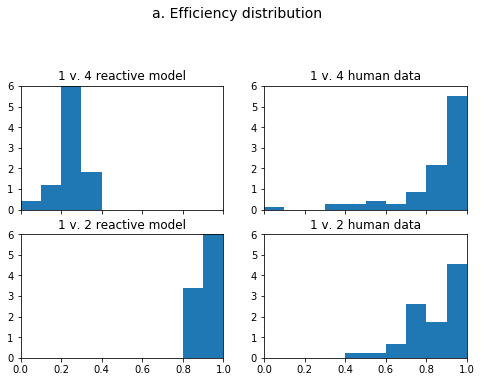

In [10]:
matplotlib.rcParams.update({'font.size': 10})

plt.subplot(221)
plt.hist(h_bal_eff, normed=True, range=(0,1))
#plt.ylim(0,1)
plt.xlim(0,1)
plt.ylim(0,6)
plt.title("1 v. 4 reactive model")
ax = plt.gca()
plt.setp( ax.get_xticklabels(), visible=False)

plt.subplot(222)
plt.hist(h_dyn_eff, normed=True, range=(0,1))
plt.xlim(0,1)
plt.ylim(0,6)
plt.title("1 v. 4 human data")
ax = plt.gca()
plt.setp( ax.get_xticklabels(), visible=False)

plt.subplot(223)
plt.xlim(0,1)
plt.ylim(0,6)
plt.hist(l_bal_eff, normed=True, range=(0,1))
plt.title("1 v. 2 reactive model")

plt.subplot(224)
plt.xlim(0,1)
plt.ylim(0,6)
plt.hist(l_dyn_eff, normed=True, range=(0,1))
plt.title("1 v. 2 human data")
plt.suptitle("a. Efficiency distribution", y = 1.1, fontsize = 14)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8,5)
plt.savefig("figures/S2_Fig(a).tiff", bbox_inches='tight' );

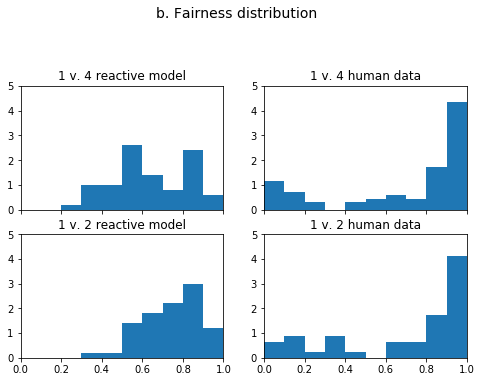

In [11]:
plt.suptitle("b. Fairness distribution", y = 1.1, fontsize = 14)

plt.subplot(221)
plt.xlim(0,1)
plt.ylim(0,5)
plt.hist(h_bal_fair, normed=True, range=(0,1))
plt.title("1 v. 4 reactive model")
ax = plt.gca()
plt.setp( ax.get_xticklabels(),  visible=False)

plt.subplot(222)
plt.xlim(0,1)
plt.ylim(0,5)
plt.hist(h_dyn_fair, normed=True, range=(0,1))
plt.title("1 v. 4 human data")
ax = plt.gca()
plt.setp( ax.get_xticklabels(),  visible=False)

plt.subplot(223)
plt.xlim(0,1)
plt.ylim(0,5)
plt.hist(l_bal_fair, normed=True, range=(0,1))
plt.title("1 v. 2 reactive model")

plt.subplot(224)
plt.xlim(0,1)
plt.ylim(0,5)
plt.hist(l_dyn_fair, normed=True, range=(0,1))
plt.title("1 v. 2 human data")

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8,5)
plt.savefig("figures/S2_Fig(b).tiff", bbox_inches='tight')

Note that the distribution of fairness scores is bimodal.

Next, we make an interaction plot comparing mean efficiency across the four conditions, and conduct a set of non-parametric statistical tests.

means:  0.246 0.842028985507 0.904 0.847101449275
kruscal-wallis w/ (K, p) = KruskalResult(statistic=112.52550850055428, pvalue=3.1388545233513937e-24)
mann-whitney b/w h_bal and h_dyn w/ (U, p) = MannwhitneyuResult(statistic=51.0, pvalue=9.44112894165894e-20)
mann-whitney b/w l_bal and l_dyn w/ (U, p) = MannwhitneyuResult(statistic=1003.5, pvalue=0.14161088131169852)
mann-whitney b/w l_bal and h_bal w/ (U, p) = MannwhitneyuResult(statistic=0.0, pvalue=2.959316775749963e-18)
mann-whitney b/w l_dyn and h_dyn w/ (U, p) = MannwhitneyuResult(statistic=1506.0, pvalue=0.32272445150158757)


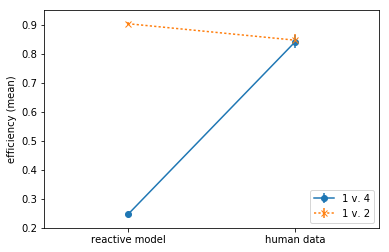

In [19]:
plt.errorbar([0,1], [np.mean(h_bal_eff), np.mean(h_dyn_eff)], 
             yerr = [np.std(h_bal_eff) / math.sqrt(len(h_bal_eff)), 
                     np.std(h_dyn_eff) / math.sqrt(len(h_dyn_eff))], 
             fmt='-o',  label = "1 v. 4")
plt.errorbar([0,1], [np.mean(l_bal_eff), np.mean(l_dyn_eff)], 
             yerr = [np.std(l_bal_eff) / math.sqrt(len(l_bal_eff)), 
                     np.std(l_dyn_eff) / math.sqrt(len(l_dyn_eff))], 
             fmt = ':x', label = "1 v. 2")
plt.xticks([0,1],['reactive model', 'human data'])
plt.xlim(-0.5, 1.5)
plt.ylim(0.2,.95)
plt.legend(loc='lower right')
plt.ylabel("efficiency (mean)")

print "means: ", np.mean(h_bal_eff), np.mean(h_dyn_eff), np.mean(l_bal_eff), np.mean(l_dyn_eff)
print "kruscal-wallis w/ (K, p) =", stats.kruskal(h_dyn_eff,l_dyn_eff,h_bal_eff,l_bal_eff)
print "mann-whitney b/w h_bal and h_dyn w/ (U, p) =", stats.mannwhitneyu(h_bal_eff, h_dyn_eff)
print "mann-whitney b/w l_bal and l_dyn w/ (U, p) =", stats.mannwhitneyu(l_bal_eff, l_dyn_eff)
print "mann-whitney b/w l_bal and h_bal w/ (U, p) =", stats.mannwhitneyu(l_bal_eff, h_bal_eff)
print "mann-whitney b/w l_dyn and h_dyn w/ (U, p) =", stats.mannwhitneyu(l_dyn_eff, h_dyn_eff)

We find a main effect of the "ballistic-dynamic" manipulation but no effect of the payoff manipulation.
Since the kruskal-wallis and mann-whitney tests compare ranks, not means, the previous plot is technically misleading. We need to report mean rank, which shows the same effect but has a less interpretable y-axis.

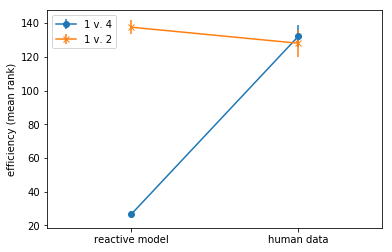

In [20]:
r = stats.rankdata(h_bal_eff + h_dyn_eff + l_bal_eff + l_dyn_eff)
tick1 = len(h_bal_eff)
tick2 = tick1 + len(h_dyn_eff)
tick3 = tick2 + len(l_bal_eff)
h_bal_ranks = (r[:tick1]) 
h_dyn_ranks = (r[tick1 : tick2])
l_bal_ranks = (r[tick2 : tick3])
l_dyn_ranks = (r[tick3 :])
plt.errorbar([0,1], [np.mean(h_bal_ranks), np.mean(h_dyn_ranks)], 
             yerr = [np.std(h_bal_ranks) / math.sqrt(len(h_bal_ranks)), 
                     np.std(h_dyn_ranks) / math.sqrt(len(h_dyn_ranks))], 
             fmt='-o',  label = "1 v. 4")
plt.errorbar([0,1], [np.mean(l_bal_ranks), np.mean(l_dyn_ranks)], 
             yerr = [np.std(l_bal_ranks) / math.sqrt(len(l_bal_ranks)), 
                     np.std(l_dyn_ranks) / math.sqrt(len(l_dyn_ranks))], 
             fmt = '-x', label = "1 v. 2")
plt.xticks([0,1],['reactive model', 'human data'])
plt.xlim(-0.5, 1.5)
#plt.ylim(0.6,.9)
plt.legend(loc='upper left')
plt.ylabel("efficiency (mean rank)")

Plot means for visualization, and compare using kruskal-wallis and post-hoc mann-whitney tests

means: 0.64067965368 0.69539246543 0.745234093213 0.692450839901
Kruskal Wallis w/ (K, p) = KruskalResult(statistic=10.380838385277277, pvalue=0.015591414155122286)
mann-whitney: h_bal vs. h_dyn  w/ (U, p) = MannwhitneyuResult(statistic=1251.0, pvalue=0.0053188868778667863)
mann-whitney: h_bal vs. l_dyn w/ (U, p) = MannwhitneyuResult(statistic=871.0, pvalue=0.020469445306015018)
mann-whitney: l_bal vs. l_dyn w/ (U,p) = MannwhitneyuResult(statistic=995.5, pvalue=0.12927705096587755)
mann-whitney: l_bal vs. h_bal w/ (U, p) = MannwhitneyuResult(statistic=845.5, pvalue=0.0026626573527750502)


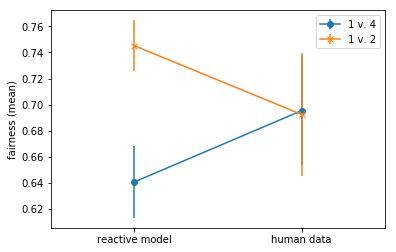

In [21]:
plt.errorbar([0,1], [np.mean(h_bal_fair), np.mean(h_dyn_fair)], 
             yerr = [np.std(h_bal_fair) / math.sqrt(len(h_bal_fair)), 
                     np.std(h_dyn_fair) / math.sqrt(len(h_dyn_fair))], 
             fmt='-o',  label = "1 v. 4")
plt.errorbar([0,1], [np.mean(l_bal_fair), np.mean(l_dyn_fair)], 
             yerr = [np.std(l_bal_fair) / math.sqrt(len(l_bal_fair)), 
                     np.std(l_dyn_fair) / math.sqrt(len(l_dyn_fair))], 
             fmt = '-x', label = "1 v. 2")
plt.xticks([0,1],['reactive model', 'human data'])
plt.xlim(-0.5, 1.5)

print "means:", np.mean(h_bal_fair), np.mean(h_dyn_fair), np.mean(l_bal_fair), np.mean(l_dyn_fair)

plt.legend(loc='best')
plt.ylabel("fairness (mean)")
print "Kruskal Wallis w/ (K, p) =", stats.mstats.kruskalwallis(h_bal_fair,l_bal_fair,h_dyn_fair, l_dyn_fair)
print "mann-whitney: h_bal vs. h_dyn  w/ (U, p) =", stats.mannwhitneyu(h_bal_fair, h_dyn_fair)
print "mann-whitney: h_bal vs. l_dyn w/ (U, p) =", stats.mannwhitneyu(h_bal_fair, l_dyn_fair)
print "mann-whitney: l_bal vs. l_dyn w/ (U,p) =", stats.mannwhitneyu(l_bal_fair, l_dyn_fair)
print "mann-whitney: l_bal vs. h_bal w/ (U, p) =", stats.mannwhitneyu(h_bal_fair, l_bal_fair)

Again, we technically want to look at mean rank rather than the raw means of fairness scores, but we find the same results:

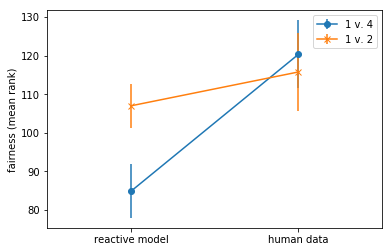

In [22]:
r = stats.rankdata(h_bal_fair + h_dyn_fair + l_bal_fair + l_dyn_fair)
tick1 = len(h_bal_fair)
tick2 = tick1 + len(h_dyn_fair)
tick3 = tick2 + len(l_bal_fair)
h_bal_ranks = (r[:tick1]) 
h_dyn_ranks = (r[tick1 : tick2])
l_bal_ranks = (r[tick2 : tick3])
l_dyn_ranks = (r[tick3 :])
plt.errorbar([0,1], [np.mean(h_bal_ranks), np.mean(h_dyn_ranks)], 
             yerr = [np.std(h_bal_ranks) / math.sqrt(len(h_bal_ranks)),
                     np.std(h_dyn_ranks) / math.sqrt(len(h_dyn_ranks))],
             fmt = '-o', label = "1 v. 4")
plt.errorbar([0,1], [np.mean(l_bal_ranks), np.mean(l_dyn_ranks)], 
             yerr = [np.std(l_bal_ranks) / math.sqrt(len(l_bal_ranks)),
                     np.std(l_dyn_ranks) / math.sqrt(len(l_dyn_ranks))],
             fmt = '-x', label = "1 v. 2")
plt.xticks([0,1],['reactive model', 'human data'])
plt.xlim(-0.5, 1.5)
plt.legend(loc='best')
plt.ylabel("fairness (mean rank)")

# Stability Analysis 

Especially in ballistic conditions, people use the random assignment of the payoffs to coordinate. One player will always go top and the other will always go bottom. The stability of this pattern isn't captured by the outcomes, so we need to check the direction sequence as well.

In [23]:
def get_direction_seq(conflict_level, cond) :
    big_list = []
    max_points = 4 if conflict_level == 'high' else 2
    for r,d,f in os.walk('./{0}_conflict_{1}/completed'.format(conflict_level,cond)):
        for files in f:
            if files.startswith('game_'):
                ts = []
                destination = r + '/' + files
                d = Data(destination).get_data()
                num_games = d[-1][0]
                red_data, blue_data = get_red_data(d), get_blue_data(d)
                for i in range(1,num_games+1) :
                    g = get_game_data(d,i)
                    # If red wins... Count it if they're on top, otherwise note that blue went top
                    if (get_red_data(g)[0][-2] == (get_red_data(g)[-1][-2] - max_points)) :
                        if (get_red_data(g)[0][2]) == 'top' :
                            ts.append('R')
                        else :
                            ts.append('B')
                    # If blue wins... Count it if they're on top, otherwise note that red went top
                    elif (get_blue_data(g)[0][-2] == (get_blue_data(g)[-1][-2] - max_points)) :
                        if (get_blue_data(g)[0][2]) == 'top' :
                            ts.append('B')
                        else :
                            ts.append('R')
                    else :
                        ts.append('T')
                big_list.append(ts)
    return big_list

In [24]:
h_bal_dir = get_direction_seq("high", "ballistic")
h_dyn_dir = get_direction_seq("high", "dynamic")
l_bal_dir = get_direction_seq("low", "ballistic")
l_dyn_dir = get_direction_seq("low", "dynamic")

```get_surprise_ts``` first builds up a conditional probability distribution giving the likelihood of observing one outcome given the previous m outcomes. Once we have this distribution, it computes Shannon's surprisal for each round of the game:

In [25]:
def get_surprise_ts (ts, num_back = 2) :
    d = defaultdict(lambda: defaultdict(int))
    surp = []
    # Build conditional distribution
    for i in range(len(ts) - num_back - 1) :
        substring = ts[i:i+num_back + 1]
        d[''.join(substring[:num_back])][substring[-1]] += 1
    # Compute surprisal (-log(p)) for each time step
    for i in range(len(ts) - num_back - 1) :
        substring = ts[i:i+num_back + 1]
        relevant_d = d[''.join(substring[:num_back])]
        # Add 1/k for virtual counts
        surp.append(-np.log2((relevant_d[substring[-1]] + 1/float(3))/float((sum(relevant_d.values()) + 1))))
    return surp

```get_big_surp``` is a wrapper function for get_surprise_ts. It builds surprisal time series for both the outcome encoding and the direction encoding, then appends the one that is lower overall to the big list of surprisal time series for all dyads in a given condition.

In [26]:
def get_big_surp (outcome_seqs, direction_seqs, num_back = 2) :
    big_surp = []
    dir_counter = 0
    for ts1, ts2 in zip(outcome_seqs, direction_seqs) :
        surp1 = get_surprise_ts(ts1, num_back)
        surp2 = get_surprise_ts(ts2, num_back)
        # Take the surprises of the most stable encoding (I'm being generous to ur strategies)
        if np.median(surp1) < np.median(surp2) :
            big_surp.append(surp1) 
        else :
            dir_counter += 1
            big_surp.append(surp2)
    return big_surp, dir_counter

We calculate the big list of surprisals for each condition:

In [27]:
### Later on, we show that other values of num_back look the same
num_back = 2
l_dyn_surp = [image for mi in get_big_surp(l_dyn, l_dyn_dir, num_back)[0] 
              for image in mi]
l_bal_surp = [image for mi in get_big_surp(l_bal, l_bal_dir, num_back)[0] 
              for image in mi]
h_dyn_surp = [image for mi in get_big_surp(h_dyn, h_dyn_dir, num_back)[0] 
              for image in mi]
h_bal_surp = [image for mi in get_big_surp(h_bal, h_bal_dir, num_back)[0] 
              for image in mi]

### S3 Text result

One minor question of interest concerns which conditions used the 'direction' encoding and which conditions used the 'outcome' coding. In other words, which conditions generally adopted which convention.
We test this using a chi-squared contingency test on the counts of how many dyads in each condition adopted each convention.

In [28]:
n = len(l_dyn)
l_dyn_freq = get_big_surp(l_dyn, l_dyn_dir)[1]
l_dyn_entry = [l_dyn_freq, n - l_dyn_freq] 

n = len(l_bal)
l_bal_freq = get_big_surp(l_bal, l_bal_dir)[1]
l_bal_entry = [l_bal_freq, n - l_bal_freq]

n = len(h_dyn)
h_dyn_freq = get_big_surp(h_dyn, h_dyn_dir)[1]
h_dyn_entry = [h_dyn_freq, n - h_dyn_freq] 

n = len(h_bal)
h_dyn_freq = get_big_surp(h_bal, h_bal_dir)[1]
h_bal_entry = [h_dyn_freq, n - h_dyn_freq]

low_pooled1, low_pooled2 = l_dyn_entry[0] + l_bal_entry[0], l_dyn_entry[1] + l_bal_entry[1]
high_pooled1, high_pooled2 = h_dyn_entry[0] + h_bal_entry[0], h_dyn_entry[1] + h_bal_entry[1]

#print stats.chi2_contingency([[low_pooled1, low_pooled2],[high_pooled1, high_pooled2]])
#print [[dyn_pooled1, dyn_pooled2],[bal_pooled1, bal_pooled2]]
res = stats.chi2_contingency([[l_dyn_entry, 
                               l_bal_entry],# High Dynamic is more likely to be outcome based than expected
                              [h_dyn_entry, 
                               h_bal_entry]])
print res
print "chi^2 =", res[0], "-> p = ", res[1]
print()
expected = res[-1]# High Ballistic is more likely to be outcome based than expected
print "If negative, it means that the observed frequency is smaller than expected"
print np.array([[l_dyn_entry, 
        l_bal_entry], 
       [h_dyn_entry,
        h_bal_entry]]) - expected
print "key:\n", np.array([[["1v2 dyn dir", "1v2 dyn out"],
        ["1v2 bal dir", "1v2 bal out"]], 
       [["1v4 dyn dir", "1v4 dyn out"],
        ["1v4 bal dir", "1v4 bal out"]]])

(85.194384807527626, 1.3795356140900484e-17, 4L, array([[[ 23.4055165 ,  27.94332071],
        [ 20.35262304,  24.29853975]],

       [[ 29.01308816,  34.63807463],
        [ 25.22877231,  30.1200649 ]]]))
chi^2 = 85.1943848075 -> p =  1.37953561409e-17
()
If negative, it means that the observed frequency is smaller than expected
[[[-12.4055165    7.05667929]
  [  7.64737696  -2.29853975]]

 [[-18.01308816  23.36192537]
  [ 22.77122769 -28.1200649 ]]]
key:
[[['1v2 dyn dir' '1v2 dyn out']
  ['1v2 bal dir' '1v2 bal out']]

 [['1v4 dyn dir' '1v4 dyn out']
  ['1v4 bal dir' '1v4 bal out']]]


We find that the full 2x2x2 matrix of is significantly different from the matrix expected if independent $\chi^2(4) = 17.18, p = .002.$

We can visualize this effect

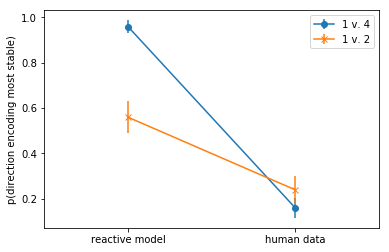

In [29]:
n = len(l_dyn)
l_dyn_p = get_big_surp(l_dyn, l_dyn_dir)[1] / float(n)
l_dyn_sd = math.sqrt(l_dyn_p * (1 - l_dyn_p) / float(n))
n = len(l_bal)
l_bal_p = get_big_surp(l_bal, l_bal_dir)[1] / float(n)
l_bal_sd = math.sqrt(l_bal_p * (1 - l_bal_p) / float(n))
n = len(h_dyn)
h_dyn_p = get_big_surp(h_dyn, h_dyn_dir)[1] / float(n)
h_dyn_sd = math.sqrt(h_dyn_p * (1 - h_dyn_p) / float(n))
n = len(h_bal)
h_bal_p = get_big_surp(h_bal, h_bal_dir)[1] / float(n)
h_bal_sd = math.sqrt(h_bal_p * (1 - h_bal_p) / float(n))
plt.errorbar([0,1], [np.mean(h_bal_p), np.mean(h_dyn_p)], 
             yerr = [h_bal_sd, h_dyn_sd],
             fmt='-o',  label = "1 v. 4")
plt.errorbar([0,1], [np.mean(l_bal_p), np.mean(l_dyn_p)], 
             yerr = [l_bal_sd, l_dyn_sd],
             fmt = '-x', label = "1 v. 2")
plt.xticks([0,1],['reactive model', 'human data'])
plt.xlim(-0.5, 1.5)
#plt.ylim(.5,1)
plt.legend(loc='best')
plt.ylabel("p(direction encoding most stable)")

### S2 Fig(c)

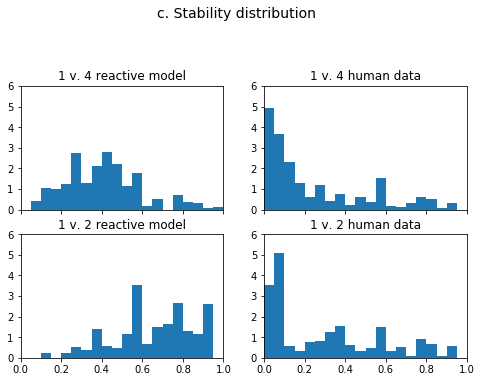

In [30]:
highest_x = 1
highest_y = 6

matplotlib.rcParams.update({'font.size': 10})

plt.suptitle("c. Stability distribution", y = 1.1, fontsize = 14)

plt.subplot(221)
plt.xlim(0,highest_x)
plt.ylim(0,highest_y)
plt.hist(h_bal_surp, normed=True, bins = 20,range = (0, highest_x))
plt.title("1 v. 4 reactive model")
ax = plt.gca()
plt.setp( ax.get_xticklabels(), visible=False)

plt.subplot(222)
plt.xlim(0,highest_x)
plt.hist(h_dyn_surp, normed=True,bins = 20,range = (0, highest_x))
plt.ylim(0,highest_y)
plt.title("1 v. 4 human data")
ax = plt.gca()
plt.setp( ax.get_xticklabels(), visible=False)

plt.subplot(223)
plt.xlim(0,highest_x)
plt.ylim(0,highest_y)
plt.hist(l_bal_surp, normed=True,bins = 20, range = (0, highest_x))
plt.title("1 v. 2 reactive model")

plt.subplot(224)
plt.xlim(0,highest_x)
plt.ylim(0,highest_y)
plt.hist(l_dyn_surp, normed=True,bins = 20,range = (0, highest_x))
plt.title("1 v. 2 human data")

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8,5)

plt.savefig("figures/S2_Fig(c).tiff", bbox_inches='tight')

Now we construct the interaction plot for stability and conduct our kruskal-wallis and mann-whitney tests

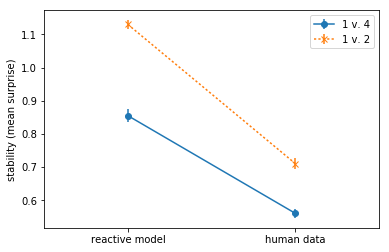

(0.8549603760875184, 0.56059372716682399, 1.1299233755659515, 0.71061397035350171)
Kruskal Wallis: w/ (K, p) = KruskalResult(statistic=1858.0642731623564, pvalue=0.0)
1 v. 4 ballistic & 1 v. 4 dynamic: mann-whitney (U, p) = MannwhitneyuResult(statistic=2440968.0, pvalue=3.6868332625651023e-117)
1 v. 2 ballistic & 1 v. 2 dynamic: mann-whitney (U, p) = MannwhitneyuResult(statistic=1622485.5, pvalue=1.6506220911661761e-183)
1 v. 4 ballistic & 1 v. 2 dynamic: mann-whitney (U, p) = MannwhitneyuResult(statistic=2507516.0, pvalue=3.8277480065003619e-30)
1 v. 4 ballistic & 1 v. 2 ballistic: mann-whitney (U, p) = MannwhitneyuResult(statistic=1511830.0, pvalue=2.7761082278235713e-159)


In [31]:
plt.errorbar([0,1], [np.mean(h_bal_surp), np.mean(h_dyn_surp)], 
             yerr = [np.std(h_bal_surp) / math.sqrt(len(h_bal_surp)), 
                     np.std(h_dyn_surp) / math.sqrt(len(h_dyn_surp))], 
             fmt='-o',  label = "1 v. 4")
plt.errorbar([0,1], [np.mean(l_bal_surp), np.mean(l_dyn_surp)], 
             yerr = [np.std(l_bal_surp) / math.sqrt(len(l_bal_surp)), 
                     np.std(l_dyn_surp) / math.sqrt(len(l_dyn_surp))],
                     fmt = ':x', label = "1 v. 2")
plt.xticks([0,1],['reactive model', 'human data'])
plt.xlim(-0.5, 1.5)
#plt.ylim(.1,.5)
plt.legend(loc='best')
plt.ylabel("stability (mean surprise)")
plt.show()
print(np.mean(h_bal_surp), np.mean(h_dyn_surp), np.mean(l_bal_surp), np.mean(l_dyn_surp))

print "Kruskal Wallis: w/ (K, p) =", stats.mstats.kruskalwallis(h_bal_surp,l_bal_surp,h_dyn_surp, l_dyn_surp)
print "1 v. 4 ballistic & 1 v. 4 dynamic: mann-whitney (U, p) =", stats.mannwhitneyu(h_bal_surp, h_dyn_surp)
print "1 v. 2 ballistic & 1 v. 2 dynamic: mann-whitney (U, p) =", stats.mannwhitneyu(l_bal_surp, l_dyn_surp)
print "1 v. 4 ballistic & 1 v. 2 dynamic: mann-whitney (U, p) =", stats.mannwhitneyu(h_bal_surp, l_dyn_surp)
print "1 v. 4 ballistic & 1 v. 2 ballistic: mann-whitney (U, p) =", stats.mannwhitneyu(h_bal_surp, l_bal_surp)

We see that there is an interaction between payoff and environment, with low stakes leading to a less stable outcome in the 'dynamic' condition than the 'ballistic' condition, and high stakes leading to a more stable outcome in the 'dynamic' condition than the 'ballistic' condition.

The same interaction is depicted when using mean rank:

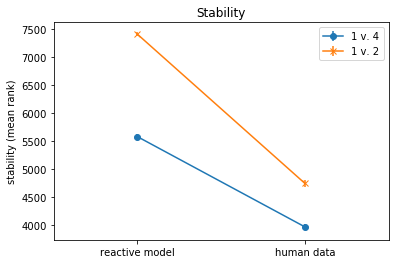

In [32]:
r = stats.rankdata(h_bal_surp + h_dyn_surp + l_bal_surp + l_dyn_surp)
tick1 = len(h_bal_surp)
tick2 = tick1 + len(h_dyn_surp)
tick3 = tick2 + len(l_bal_surp)
h_bal_ranks = (r[:tick1]) 
h_dyn_ranks = (r[tick1 : tick2])
l_bal_ranks = (r[tick2 : tick3])
l_dyn_ranks = (r[tick3 :])
plt.errorbar([0,1], [np.mean(h_bal_ranks), np.mean(h_dyn_ranks)], 
             yerr = [np.std(h_bal_ranks) / math.sqrt(len(h_bal_ranks)),
                     np.std(h_dyn_ranks) / math.sqrt(len(h_dyn_ranks))],
             fmt = '-o', label = "1 v. 4")
plt.errorbar([0,1], [np.mean(l_bal_ranks), np.mean(l_dyn_ranks)], 
             yerr = [np.std(l_bal_ranks) / math.sqrt(len(l_bal_ranks)),
                     np.std(l_dyn_ranks) / math.sqrt(len(l_dyn_ranks))],
             fmt = '-x', label = "1 v. 2")
plt.xticks([0,1],['reactive model', 'human data'])
plt.xlim(-0.5, 1.5)
plt.title("Stability")
plt.legend(loc='best')
plt.ylabel("stability (mean rank)")

## Fig. 2

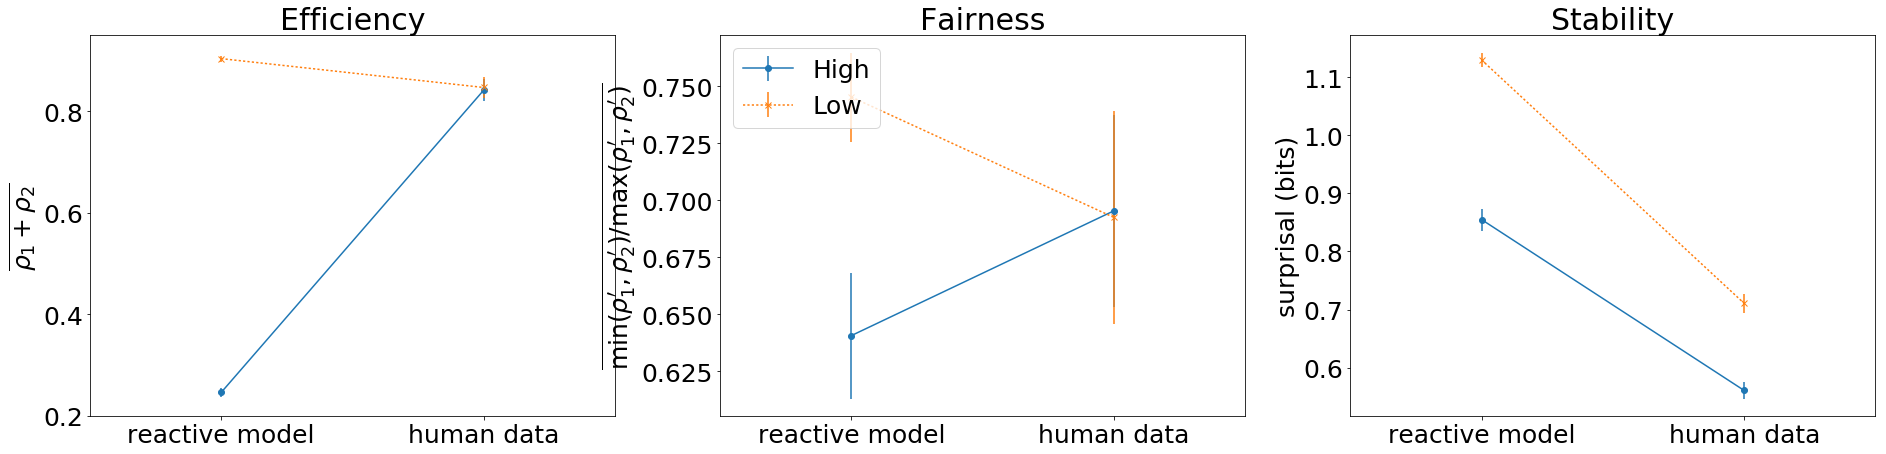

In [34]:
plt.subplot(131)
plt.errorbar([0,1], [np.mean(h_bal_eff), np.mean(h_dyn_eff)], 
             yerr = [np.std(h_bal_eff) / math.sqrt(len(h_bal_eff)), 
                     np.std(h_dyn_eff) / math.sqrt(len(h_dyn_eff))], 
             fmt='-o',  label = "High")
plt.errorbar([0,1], [np.mean(l_bal_eff), np.mean(l_dyn_eff)], 
             yerr = [np.std(l_bal_eff) / math.sqrt(len(l_bal_eff)), 
                     np.std(l_dyn_eff) / math.sqrt(len(l_dyn_eff))], 
             fmt = ':x', label = "Low")
plt.xticks([0,1],['reactive model', 'human data'])
plt.xlim(-0.5, 1.5)
plt.ylim(0.2,.95)
plt.ylabel(r"$\overline{\rho_1 + \rho_2}$")
plt.title("Efficiency")


plt.subplot(132)
plt.errorbar([0,1], [np.mean(h_bal_fair), np.mean(h_dyn_fair)], 
             yerr = [np.std(h_bal_fair) / math.sqrt(len(h_bal_fair)), 
                     np.std(h_dyn_fair) / math.sqrt(len(h_dyn_fair))], 
             fmt='-o',  label = "High")
plt.errorbar([0,1], [np.mean(l_bal_fair), np.mean(l_dyn_fair)], 
             yerr = [np.std(l_bal_fair) / math.sqrt(len(l_bal_fair)), 
                     np.std(l_dyn_fair) / math.sqrt(len(l_dyn_fair))], 
             fmt = ':x', label = "Low")
plt.xticks([0,1],['reactive model', 'human data'])
plt.xlim(-0.5, 1.5)
plt.legend(loc='upper left')
plt.ylabel(r"$\overline{\min(\rho_1', \rho_2') / \max(\rho_1', \rho_2')}$")
plt.title("Fairness")

plt.subplot(133)
plt.errorbar([0,1], [np.mean(h_bal_surp), np.mean(h_dyn_surp)], 
             yerr = [np.std(h_bal_surp) / math.sqrt(len(h_bal_surp)), 
                     np.std(h_dyn_surp) / math.sqrt(len(h_dyn_surp))], 
             fmt='-o',  label = "High")
plt.errorbar([0,1], [np.mean(l_bal_surp), np.mean(l_dyn_surp)], 
             yerr = [np.std(l_bal_surp) / math.sqrt(len(l_bal_surp)), 
                     np.std(l_dyn_surp) / math.sqrt(len(l_dyn_surp))],
                     fmt = ':x', label = "Low")
plt.xticks([0,1],['reactive model', 'human data'])
plt.xlim(-0.5, 1.5)
#plt.legend(loc='best')
plt.ylabel(r"surprisal (bits)")
plt.title("Stability")
matplotlib.rcParams.update({'font.size': 25})
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(32,7)
plt.savefig("figures/Fig2.tiff")

## S3 Fig (mean rank)

137.6 128.054347826 26.52 132.224637681
kruscal-wallis significant w/ p = KruskalResult(statistic=112.52550850055428, pvalue=3.1388545233513937e-24)
mann-whitney shows significant diff b/w h_bal and h_dyn w/ p = MannwhitneyuResult(statistic=51.0, pvalue=9.44112894165894e-20) 50 69
mann-whitney shows significant diff b/w l_bal and l_dyn w/ p = MannwhitneyuResult(statistic=1003.5, pvalue=0.14161088131169852) 50 46
mann-whitney shows significant diff b/w l_bal and h_bal w/ p = MannwhitneyuResult(statistic=0.0, pvalue=2.959316775749963e-18)
mann-whitney shows significant diff b/w l_dyn and h_dyn w/ p = MannwhitneyuResult(statistic=1506.0, pvalue=0.32272445150158757)


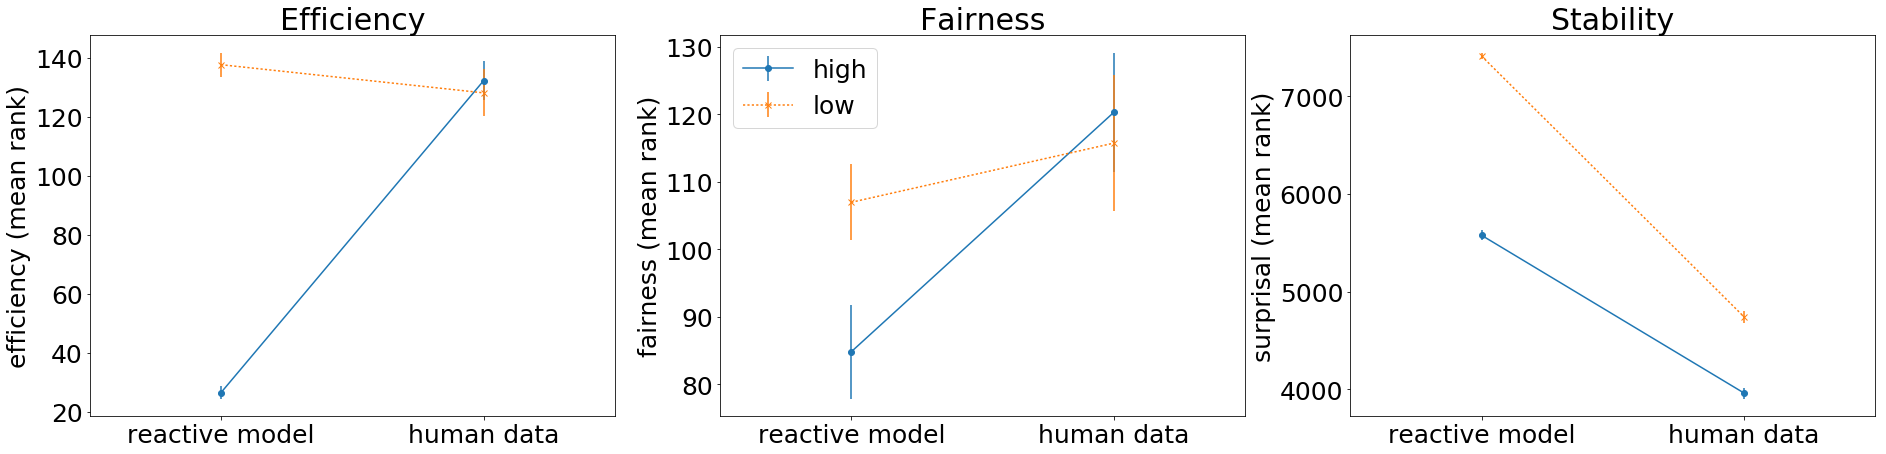

In [35]:
plt.subplot(131)

r = stats.rankdata(h_bal_eff + h_dyn_eff + l_bal_eff + l_dyn_eff)
tick1 = len(h_bal_eff)
tick2 = tick1 + len(h_dyn_eff)
tick3 = tick2 + len(l_bal_eff)
h_bal_ranks = (r[:tick1]) 
h_dyn_ranks = (r[tick1 : tick2])
l_bal_ranks = (r[tick2 : tick3])
l_dyn_ranks = (r[tick3 :])
plt.errorbar([0,1], [np.mean(h_bal_ranks), np.mean(h_dyn_ranks)], 
             yerr = [np.std(h_bal_ranks) / math.sqrt(len(h_bal_ranks)), 
                     np.std(h_dyn_ranks) / math.sqrt(len(h_dyn_ranks))], 
             fmt='-o',  label = "high")
plt.errorbar([0,1], [np.mean(l_bal_ranks), np.mean(l_dyn_ranks)], 
             yerr = [np.std(l_bal_ranks) / math.sqrt(len(l_bal_ranks)), 
                     np.std(l_dyn_ranks) / math.sqrt(len(l_dyn_ranks))], 
             fmt = ':x', label = "low")
plt.xticks([0,1],['reactive model', 'human data'])
plt.xlim(-0.5, 1.5)
#plt.ylim(0.6,.9)
plt.title("Efficiency")
plt.ylabel("efficiency (mean rank)")

print np.mean(l_bal_ranks), np.mean(l_dyn_ranks), np.mean(h_bal_ranks), np.mean(h_dyn_ranks)
print "kruscal-wallis significant w/ p =", stats.kruskal(h_dyn_eff,l_dyn_eff,h_bal_eff,l_bal_eff)
print "mann-whitney shows significant diff b/w h_bal and h_dyn w/ p =", stats.mannwhitneyu(h_bal_eff, h_dyn_eff), len(h_bal_eff), len(h_dyn_eff)
print "mann-whitney shows significant diff b/w l_bal and l_dyn w/ p =", stats.mannwhitneyu(l_bal_eff, l_dyn_eff), len(l_bal_eff), len(l_dyn_eff)
print "mann-whitney shows significant diff b/w l_bal and h_bal w/ p =", stats.mannwhitneyu(l_bal_eff, h_bal_eff)
print "mann-whitney shows significant diff b/w l_dyn and h_dyn w/ p =", stats.mannwhitneyu(l_dyn_eff, h_dyn_eff)

plt.subplot(132)
r = stats.rankdata(h_bal_fair + h_dyn_fair + l_bal_fair + l_dyn_fair)
tick1 = len(h_bal_fair)
tick2 = tick1 + len(h_dyn_fair)
tick3 = tick2 + len(l_bal_fair)
h_bal_ranks = (r[:tick1]) 
h_dyn_ranks = (r[tick1 : tick2])
l_bal_ranks = (r[tick2 : tick3])
l_dyn_ranks = (r[tick3 :])
plt.errorbar([0,1], [np.mean(h_bal_ranks), np.mean(h_dyn_ranks)], 
             yerr = [np.std(h_bal_ranks) / math.sqrt(len(h_bal_ranks)),
                     np.std(h_dyn_ranks) / math.sqrt(len(h_dyn_ranks))],
             fmt = '-o', label = "high")
plt.errorbar([0,1], [np.mean(l_bal_ranks), np.mean(l_dyn_ranks)], 
             yerr = [np.std(l_bal_ranks) / math.sqrt(len(l_bal_ranks)),
                     np.std(l_dyn_ranks) / math.sqrt(len(l_dyn_ranks))],
             fmt = ':x', label = "low")
plt.xticks([0,1],['reactive model', 'human data'])
plt.xlim(-0.5, 1.5)
plt.legend(loc='best')
plt.title("Fairness")
plt.ylabel("fairness (mean rank)")


plt.subplot(133)
r = stats.rankdata(h_bal_surp + h_dyn_surp + l_bal_surp + l_dyn_surp)
tick1 = len(h_bal_surp)
tick2 = tick1 + len(h_dyn_surp)
tick3 = tick2 + len(l_bal_surp)
h_bal_ranks = (r[:tick1]) 
h_dyn_ranks = (r[tick1 : tick2])
l_bal_ranks = (r[tick2 : tick3])
l_dyn_ranks = (r[tick3 :])
plt.errorbar([0,1], [np.mean(h_bal_ranks), np.mean(h_dyn_ranks)], 
             yerr = [np.std(h_bal_ranks) / math.sqrt(len(h_bal_ranks)),
                     np.std(h_dyn_ranks) / math.sqrt(len(h_dyn_ranks))],
             fmt = '-o', label = "high")
plt.errorbar([0,1], [np.mean(l_bal_ranks), np.mean(l_dyn_ranks)], 
             yerr = [np.std(l_bal_ranks) / math.sqrt(len(l_bal_ranks)),
                     np.std(l_dyn_ranks) / math.sqrt(len(l_dyn_ranks))],
             fmt = ':x', label = "low")
plt.xticks([0,1],['reactive model', 'human data'])
plt.xlim(-0.5, 1.5)
plt.title("Stability")
plt.ylabel("surprisal (mean rank)")

matplotlib.rcParams.update({'font.size': 25})
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(32,7)
plt.savefig("figures/S3_Fig.tiff")

## S4 Fig (surprisal CDFs)

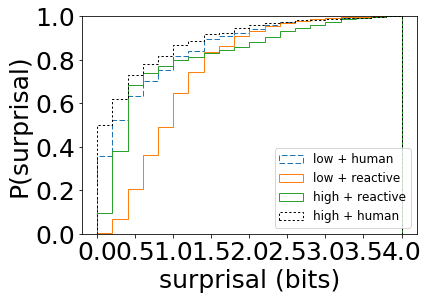

In [36]:
plt.hist(l_dyn_surp, range = (0, 4), bins = 20, cumulative = True, normed = True, histtype = 'step', label = 'low + human', linestyle = 'dashed')
plt.hist(l_bal_surp, range = (0, 4), bins = 20,cumulative = True, normed = True, histtype = 'step', label = 'low + reactive')
plt.hist(h_bal_surp, range = (0, 4), bins = 20,cumulative = True, normed = True, histtype = 'step', label = 'high + reactive')
plt.hist(h_dyn_surp, range = (0, 4), bins = 20,cumulative = True, normed = True, histtype = 'step', label = 'high + human', color = 'black', ls = 'dotted')

matplotlib.rcParams.update({'font.size': 12})
plt.legend(loc='lower right')
plt.xlabel("surprisal (bits)")
plt.ylabel("P(surprisal)")
plt.ylim(0,1)

plt.savefig("figures/S4_Fig.tiff")

## S5 Fig

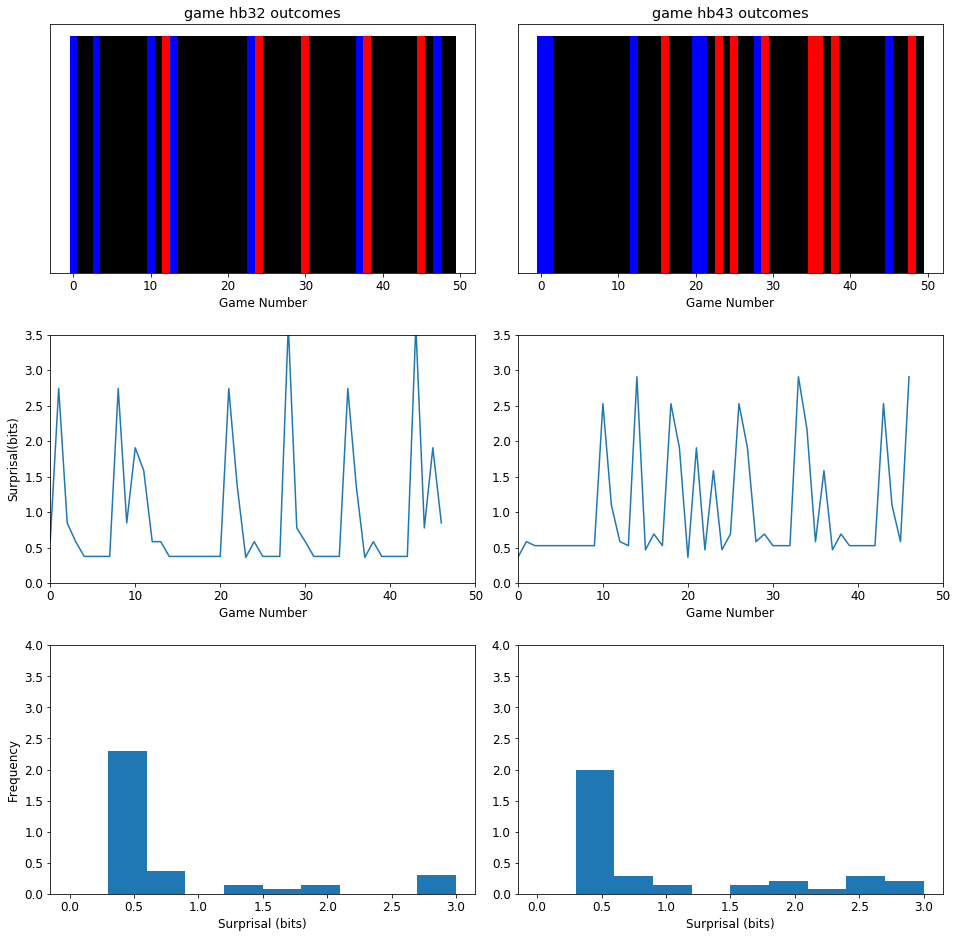

In [37]:
def plot_sequence (seq, title = "") :
    new_l1 = [t for t in seq]
    for i,s in enumerate(seq):
        if s == 'T' :
            new_l1[i]='black'
        elif s == 'B' :
            new_l1[i] = 'blue'
        elif s == 'R' :
            new_l1[i] = 'red'
    plt.bar(range(len(seq)), np.ones(len(seq)), width = 1, color = new_l1)
    plt.title(title)
    plt.xlabel("Game Number")
    frame1 = plt.gca()
    frame1.axes.get_yaxis().set_visible(False)
    matplotlib.rcParams.update({'font.size': 12})

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 16)

## asdf 
out_seq32 = get_outcome_seq("high", "ballistic")[32]
out_seq43 = get_outcome_seq("high", "ballistic")[43]

plt.subplot(321)
plot_sequence(out_seq32, title = "game hb32 outcomes")

plt.subplot(322)
plot_sequence(out_seq43, title = "game hb43 outcomes")

num_back = 2

matplotlib.rcParams.update({'font.size': 12})
plt.subplot(323)
plot(get_surprise_ts(out_seq32))
plt.ylim([0, 3.5])
plt.ylabel("Surprisal(bits)")
plt.xlim([0, 50])
plt.xlabel("Game Number")

plt.subplot(324)
plot(get_surprise_ts(out_seq43))
plt.ylim([0, 3.5])
plt.xlim([0, 50])
plt.xlabel("Game Number")

plt.subplot(325)
plt.hist(get_surprise_ts(out_seq32), range = (0, 3), normed=True)
plt.ylim([0,4])
plt.xlabel("Surprisal (bits)")
plt.ylabel("Frequency")

plt.subplot(326)
plt.hist(get_surprise_ts(out_seq43), range = (0, 3), normed=True)
plt.ylim([0,4])
plt.xlabel("Surprisal (bits)")

subplots_adjust(wspace=0.1, hspace=0.25)
plt.savefig("figures/S5_Fig.tiff")

## S6 Fig (different look-back values)

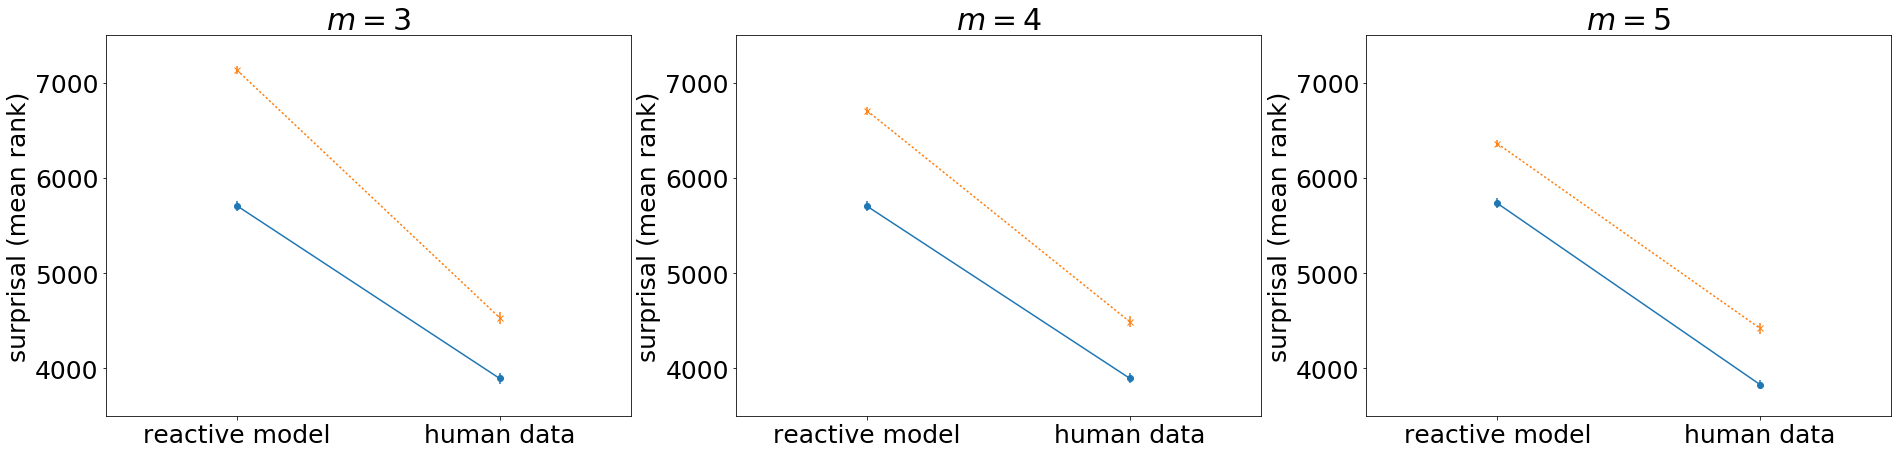

In [40]:
num_back = 3
alt_l_dyn_surp = [image for mi in get_big_surp(l_dyn, l_dyn_dir, num_back)[0] for image in mi]
alt_l_bal_surp = [image for mi in get_big_surp(l_bal, l_bal_dir, num_back)[0] for image in mi]
alt_h_dyn_surp = [image for mi in get_big_surp(h_dyn, h_dyn_dir, num_back)[0] for image in mi]
alt_h_bal_surp = [image for mi in get_big_surp(h_bal, h_bal_dir, num_back)[0] for image in mi]

plt.subplot(131)
r = stats.rankdata(alt_h_bal_surp + alt_h_dyn_surp + alt_l_bal_surp + alt_l_dyn_surp)
tick1 = len(alt_h_bal_surp)
tick2 = tick1 + len(alt_h_dyn_surp)
tick3 = tick2 + len(alt_l_bal_surp)
alt_h_bal_ranks = (r[:tick1]) 
alt_h_dyn_ranks = (r[tick1 : tick2])
alt_l_bal_ranks = (r[tick2 : tick3])
alt_l_dyn_ranks = (r[tick3 :])
plt.errorbar([0,1], [np.mean(alt_h_bal_ranks), np.mean(alt_h_dyn_ranks)], 
             yerr = [np.std(alt_h_bal_ranks) / math.sqrt(len(alt_h_bal_ranks)),
                     np.std(alt_h_dyn_ranks) / math.sqrt(len(alt_h_dyn_ranks))],
             fmt = '-o', label = "high")
plt.errorbar([0,1], [np.mean(alt_l_bal_ranks), np.mean(alt_l_dyn_ranks)], 
             yerr = [np.std(alt_l_bal_ranks) / math.sqrt(len(alt_l_bal_ranks)),
                     np.std(alt_l_dyn_ranks) / math.sqrt(len(alt_l_dyn_ranks))],
             fmt = ':x', label = "low")
plt.xticks([0,1],['reactive model', 'human data'])
plt.xlim(-0.5, 1.5)
plt.ylim(3500, 7500)
plt.title("$m = 3$")
plt.ylabel("surprisal (mean rank)")

num_back = 4
alt_l_dyn_surp = [image for mi in get_big_surp(l_dyn, l_dyn_dir, num_back)[0] for image in mi]
alt_l_bal_surp = [image for mi in get_big_surp(l_bal, l_bal_dir, num_back)[0] for image in mi]
alt_h_dyn_surp = [image for mi in get_big_surp(h_dyn, h_dyn_dir, num_back)[0] for image in mi]
alt_h_bal_surp = [image for mi in get_big_surp(h_bal, h_bal_dir, num_back)[0] for image in mi]


plt.subplot(132)
r = stats.rankdata(alt_h_bal_surp + alt_h_dyn_surp + alt_l_bal_surp + alt_l_dyn_surp)
tick1 = len(alt_h_bal_surp)
tick2 = tick1 + len(alt_h_dyn_surp)
tick3 = tick2 + len(alt_l_bal_surp)
alt_h_bal_ranks = (r[:tick1]) 
alt_h_dyn_ranks = (r[tick1 : tick2])
alt_l_bal_ranks = (r[tick2 : tick3])
alt_l_dyn_ranks = (r[tick3 :])
plt.errorbar([0,1], [np.mean(alt_h_bal_ranks), np.mean(alt_h_dyn_ranks)], 
             yerr = [np.std(alt_h_bal_ranks) / math.sqrt(len(alt_h_bal_ranks)),
                     np.std(alt_h_dyn_ranks) / math.sqrt(len(alt_h_dyn_ranks))],
             fmt = '-o', label = "high")
plt.errorbar([0,1], [np.mean(alt_l_bal_ranks), np.mean(alt_l_dyn_ranks)], 
             yerr = [np.std(alt_l_bal_ranks) / math.sqrt(len(alt_l_bal_ranks)),
                     np.std(alt_l_dyn_ranks) / math.sqrt(len(alt_l_dyn_ranks))],
             fmt = ':x', label = "low")
plt.xticks([0,1],['reactive model', 'human data'])
plt.xlim(-0.5, 1.5)
plt.ylim(3500, 7500)
plt.title("$m = 4$")
plt.ylabel("surprisal (mean rank)")

num_back = 5
alt_l_dyn_surp = [image for mi in get_big_surp(l_dyn, l_dyn_dir, num_back)[0] for image in mi]
alt_l_bal_surp = [image for mi in get_big_surp(l_bal, l_bal_dir, num_back)[0] for image in mi]
alt_h_dyn_surp = [image for mi in get_big_surp(h_dyn, h_dyn_dir, num_back)[0] for image in mi]
alt_h_bal_surp = [image for mi in get_big_surp(h_bal, h_bal_dir, num_back)[0] for image in mi]


plt.subplot(133)
r = stats.rankdata(alt_h_bal_surp + alt_h_dyn_surp + alt_l_bal_surp + alt_l_dyn_surp)
tick1 = len(alt_h_bal_surp)
tick2 = tick1 + len(alt_h_dyn_surp)
tick3 = tick2 + len(alt_l_bal_surp)
alt_h_bal_ranks = (r[:tick1]) 
alt_h_dyn_ranks = (r[tick1 : tick2])
alt_l_bal_ranks = (r[tick2 : tick3])
alt_l_dyn_ranks = (r[tick3 :])
plt.errorbar([0,1], [np.mean(alt_h_bal_ranks), np.mean(alt_h_dyn_ranks)], 
             yerr = [np.std(alt_h_bal_ranks) / math.sqrt(len(alt_h_bal_ranks)),
                     np.std(alt_h_dyn_ranks) / math.sqrt(len(alt_h_dyn_ranks))],
             fmt = '-o', label = "high")
plt.errorbar([0,1], [np.mean(alt_l_bal_ranks), np.mean(alt_l_dyn_ranks)], 
             yerr = [np.std(alt_l_bal_ranks) / math.sqrt(len(alt_l_bal_ranks)),
                     np.std(alt_l_dyn_ranks) / math.sqrt(len(alt_l_dyn_ranks))],
             fmt = ':x', label = "low")
plt.xticks([0,1],['reactive model', 'human data'])
plt.xlim(-0.5, 1.5)
plt.ylim(3500, 7500)
plt.title("$m = 5$")
plt.ylabel("surprisal (mean rank)")

matplotlib.rcParams.update({'font.size': 25})
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(32,7)
plt.savefig("figures/S6_Fig.tiff")

# Peeloff Time Analysis 

First, we classify participants' heading at each point in time as going toward the top or going toward the bottom.


In [41]:
import numpy.ma as ma
def going_toward_bottom (a) :
    return np.ma.getmaskarray(ma.masked_inside(a, 91, 269))
def going_toward_top (a) :
    return np.ma.getmaskarray(ma.masked_less(a % 271, 90))

We then track the point at which the lower switches from pursuing the high payoff target to pursuing the low payoff target


In [42]:
def peeloff_helper (d, i) :
    g = get_game_data(d,i)
    red_data, blue_data = get_red_data(g), get_blue_data(g)
    blue_change = blue_data[-1][-2] - blue_data[0][-2]
    red_change = red_data[-1][-2] - red_data[0][-2]
    if blue_change >= 2 :
        winner_data, loser_data = blue_data, red_data 
        loser_starting = 270
    elif red_change >= 2 :
        winner_data, loser_data = red_data, blue_data
        loser_starting = 90
    else : # They tied, so noone peeled off 
        return 1
    loser_away_mask = (going_toward_top(loser_data['heading']) if loser_data[0][2] == 'bottom' 
                       else (going_toward_bottom(loser_data['heading'])))
    loser_toward_mask = (going_toward_bottom(loser_data['heading']) if loser_data[0][2] == 'bottom' 
                        else (going_toward_top(loser_data['heading'])))
    # If they haven't clicked anything for half the game (or wait so long that they go toward it and lose) don't count it
    no_action_data = loser_data[loser_data['heading'] == loser_starting]
    if (len(no_action_data) > 13) or (len(loser_data[loser_away_mask]) == 0) :
        peeloff = np.nan
    # if they never go toward the high payoff, count as t = 0
    elif len(loser_data[loser_toward_mask]) == 0 :
        peeloff = 0
    # Otherwise, calculate peel-off percentage
    else :   
        winner_mask = winner_data['pointsearned'] > winner_data[0][-2]
        peeloff = loser_data[loser_away_mask][0][1] / float(winner_data[winner_mask][0][1])
    return peeloff

This is a wrapper function for the helper above, which performs this analysis for every game in the given condition.

In [43]:
def get_peeloff_times(conflict_level) :
    peeloff_times = np.array([])
    num_games = 50 if conflict_level == 'high' else 60
    for r,d,f in os.walk('./{0}_conflict_ballistic/completed'.format(conflict_level)):
        for files in f:
            if files.startswith('game_'):
                local_ts = []
                destination = r + '/' + files
                d = Data(destination).get_data()
                num_games = d[-1][0]
                for i in range(1,num_games+1) :
                    local_ts.append(peeloff_helper(d, i))
                peeloff_times = np.append(peeloff_times, local_ts)
    return peeloff_times.reshape((len(peeloff_times) / num_games, num_games))


Compute the peeloff times (pot)


In [44]:
# testing peeloff function
h_pot = get_peeloff_times('high')
l_pot = get_peeloff_times('low')


Use this function to get the predicted values according to a lowess regression


In [45]:
from numpy import nanmean
import scipy.interpolate as interp
import statsmodels.api as sm

def get_lowess_ts (outcomes, frac) :
    lowess = sm.nonparametric.lowess
    x = range(len(outcomes[0]))
    y = nanmean(outcomes, axis = 0)
    z = lowess(y, x, return_sorted = True, is_sorted = True, frac = frac)
    return z.T[1]

Use to bootstrap lowess regressions


In [46]:
choice = random.choice
def bootstrap_lowess (outcomes) :
    counter = 0
    l = []
    for t in outcomes.T :
        # bootstrap new sample
        values = [choice(t) for _ in xrange(len(t))]
        l.append(values)
    return get_lowess_ts(np.array(l).T, 1./3)

def get_bounds (outcomes) :
    big_a = np.zeros((1000,len(outcomes[0])))
    upper_int = []
    lower_int = []
    for i in range(1000) :
        new_curve = bootstrap_lowess (outcomes)
        big_a[i] = new_curve
    for t in big_a.T :
        upper_int.append(sorted(t)[841])
        lower_int.append(sorted(t)[159])
    return (lower_int, upper_int)

Precompute +1SD and -1SD envelopes (gives an interval of what we COULD have observed if we'd constructed our local regression from a slightly different sample)


In [47]:
l_lower, l_upper = get_bounds(l_pot) 
h_lower, h_upper = get_bounds(h_pot) 

Plot the nonparametric regression curves for each condition, as well as the +/- 1SD envelope around each curve


## Fig 3(a)

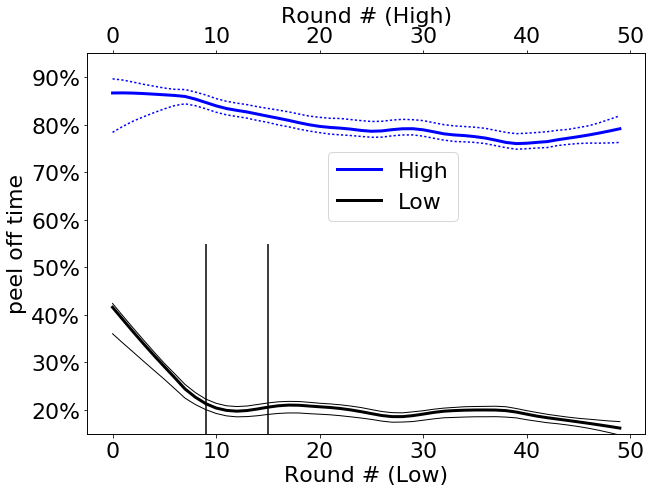

In [53]:
frac = 1./3
z1 = get_lowess_ts(l_pot, frac)
z2 = get_lowess_ts(h_pot, frac)

fig = plt.figure()

ax1 = fig.add_subplot(111)
ax1.set_xlabel("Round # (Low)")
ax1.plot(l_lower, 'k-', lw = 1)
ax1.plot(l_upper, 'k-', lw = 1)
low_line, = ax1.plot(z1,'k-', lw = 3, label = 'low')
plt.ylabel("peel off time")
ax1.vlines(9, .15,.55)
ax1.vlines(15, .15, .55)

ax2 = ax1.twiny()
ax2.set_xlabel("Round # (High)")
high_line, = ax2.plot(z2, 'b-', lw = 3, label = 'high')
ax2.plot(h_lower, 'b:')
ax2.plot(h_upper, 'b:')
plt.yticks(np.linspace(.10,.90,num = 9), ["10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%"])
plt.ylim(.15,.95)
fig.legend((high_line, low_line), ("High", "Low"), loc = (.5,.55) )
fig.set_size_inches(10,7)
matplotlib.rcParams.update({'font.size': 22})

plt.savefig("figures/Fig3(a).tiff", bbox_inches='tight' )

Note that conflict (measured by peel-off time) is greater in the 'high' condition than the 'low' condition in the initial window, but this relationship flips in the later window. We now test this observation directly on the data:

## Fig 3(b)

Kruskal Wallis significant w/ p = KruskalResult(statistic=1864.8988268382234, pvalue=0.0)
Mann-whitney @ Beginning MannwhitneyuResult(statistic=43357.5, pvalue=1.0374217345363178e-28)
n_1 =  442 n_2 =  350
Mann-whitney @ End MannwhitneyuResult(statistic=352104.0, pvalue=0.0)
n_1 =  1747 n_2 =  1850
Mann-whitney @ High MannwhitneyuResult(statistic=299031.5, pvalue=0.0014833912300837697)
Mann-whitney @ Low MannwhitneyuResult(statistic=340734.5, pvalue=5.5151766492358429e-05)


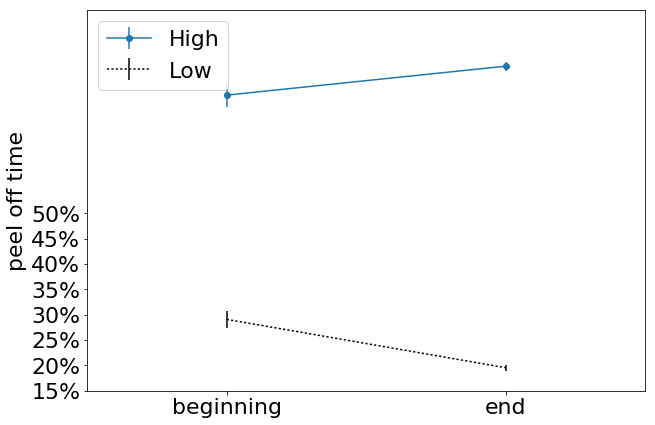

In [55]:
# Gotta filter out nans
l_pot_beg = np.array([item for sublist in [t[:9] for t in l_pot] for item in sublist])
l_pot_beg = list(l_pot_beg[~numpy.isnan(l_pot_beg)])

l_pot_end = np.array([item for sublist in [t[15:] for t in l_pot] for item in sublist])
l_pot_end = list(l_pot_end[~numpy.isnan(l_pot_end)])

h_pot_beg = np.array([item for sublist in [t[:7] for t in h_pot] for item in sublist])
h_pot_beg = list(h_pot_beg[~numpy.isnan(h_pot_beg)])

h_pot_end = np.array([item for sublist in [t[13:] for t in h_pot] for item in sublist])
h_pot_end = list(h_pot_end[~numpy.isnan(h_pot_end)])

plt.errorbar([0,1], [np.mean(h_pot_beg), np.mean(h_pot_end)], 
             yerr = [np.std(h_pot_beg) / math.sqrt(len(h_pot_beg)),
                     np.std(h_pot_end) / math.sqrt(len(h_pot_end))],
             fmt = '-o', label = "High")
plt.errorbar([0,1], [np.mean(l_pot_beg), np.mean(l_pot_end)], 
             yerr = [np.std(l_pot_beg) / math.sqrt(len(l_pot_beg)),
                     np.std(l_pot_end) / math.sqrt(len(l_pot_end))],
             fmt = 'k:', label = "Low")
plt.xticks([0,1],['beginning', 'end'])
plt.xlim(-0.5, 1.5)
#plt.title("(b)")
plt.legend(loc='best')
plt.ylabel("peel off time")
plt.ylim(.15,.9)
plt.yticks([.15,.20,.25,.30,.35,.40,.45,.50],["15%", "20%", "25%", "30%", "35%", "40%", "45%", "50%"])
print "Kruskal Wallis significant w/ p =", stats.mstats.kruskalwallis(l_pot_beg,l_pot_end,h_pot_beg, h_pot_end)
print "Mann-whitney @ Beginning", stats.mannwhitneyu(l_pot_beg, h_pot_beg)
print "n_1 = ", size(l_pot_beg), "n_2 = ", size(h_pot_beg)
print "Mann-whitney @ End", stats.mannwhitneyu(l_pot_end, h_pot_end)
print "n_1 = ", size(l_pot_end), "n_2 = ", size(h_pot_end)
print "Mann-whitney @ High", stats.mannwhitneyu(h_pot_beg, h_pot_end)
print "Mann-whitney @ Low", stats.mannwhitneyu(l_pot_beg, l_pot_end)
matplotlib.rcParams.update({'font.size': 22})
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10,7)

plt.savefig("figures/Fig3(b).tiff", bbox_inches = 'tight')
#fig.set_size_inches(32,7)

## S2 Table

In [57]:
l_cross_over = 12
h_cross_over = 10
percentage_list = np.linspace(.06, .16, 6)
s_tab3 = np.zeros((6,7))
for i in range(6) :
    percentage = percentage_list[i]
    l_pot_left = l_cross_over - math.floor(60*percentage)
    l_pot_right = l_cross_over + math.floor(60*percentage)
    h_pot_left = h_cross_over - math.floor(50*percentage)
    h_pot_right = h_cross_over + math.floor(50*percentage)

    l_pot_beg = np.array([item for sublist in [t[:l_pot_left] for t in l_pot] for item in sublist])
    l_pot_beg = list(l_pot_beg[~numpy.isnan(l_pot_beg)])
    l_beg_mean = round(np.mean(l_pot_beg),2)
    
    l_pot_end = np.array([item for sublist in [t[l_pot_right:] for t in l_pot] for item in sublist])
    l_pot_end = list(l_pot_end[~numpy.isnan(l_pot_end)])
    l_end_mean = round(np.mean(l_pot_end),2)
    
    h_pot_beg = np.array([item for sublist in [t[:h_pot_left] for t in h_pot] for item in sublist])
    h_pot_beg = list(h_pot_beg[~numpy.isnan(h_pot_beg)])
    h_beg_mean = round(np.mean(h_pot_beg),2)

    h_pot_end = np.array([item for sublist in [t[h_pot_right:] for t in h_pot] for item in sublist])
    h_pot_end = list(h_pot_end[~numpy.isnan(h_pot_end)])
    h_end_mean = round(np.mean(h_pot_end),2)

    kw_p = round(stats.mstats.kruskalwallis(l_pot_beg,l_pot_end,h_pot_beg, h_pot_end)[1],3)
    pval_beg = round(stats.mannwhitneyu(l_pot_beg, h_pot_beg)[1], 3)
    pval_end = round(stats.mannwhitneyu(l_pot_end, h_pot_end)[1], 3)
    s_tab3[i] = [kw_p, l_beg_mean, h_beg_mean, pval_beg, l_end_mean, h_end_mean, pval_end]

print(s_tab3)

[[ 0.     0.29   0.73   0.     0.2    0.79   0.   ]
 [ 0.     0.31   0.72   0.     0.19   0.79   0.   ]
 [ 0.     0.34   0.68   0.     0.19   0.79   0.   ]
 [ 0.     0.35   0.61   0.     0.19   0.79   0.   ]
 [ 0.     0.36   0.54   0.041  0.19   0.79   0.   ]
 [ 0.     0.34   0.37   0.158  0.19   0.78   0.   ]]


C:\Users\Squanchy\Anaconda3\envs\python2\lib\site-packages\ipykernel\__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Squanchy\Anaconda3\envs\python2\lib\site-packages\ipykernel\__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Squanchy\Anaconda3\envs\python2\lib\site-packages\ipykernel\__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Squanchy\Anaconda3\envs\python2\lib\site-packages\ipykernel\__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
